# Expectation-maximization algorithm

## Introduction

In this exercise you will segment three tissue classes in an MR image based on a generative model which you will fit to the image data. You will perform the Expectation-Maximization algorithm to fit the model parameters.
The MR data for this exercise consists of a 2-dimensional slice of a brain scan in the axial
orientation. The file _segmentData.mat_ contains the original slice as well as a mask that excludes
non-brain tissues such as eyeballs, fat, skin, etc. The file _correctedData.mat_ contains the same
image, but after it has been corrected for the MR bias field artifact using the method described in
section 3.5. It is this image you will be modeling.

### Instructions for your report
Your report should be structured as follows:
* **Introduction**: a short summary of what your report is about, perhaps with a recap of some of the equations you'll be using in your solution.
* **Task 1, ..., 5**: for each specific task listed below, your code (in code cells), your results (as figures) as well as explanations of what is computed and what is shown in the figures (in Markdown cells). 
* **Conclusion**: a short summary of your findings.

This introduction should **not** be part of your report.

### Input data and code hints
Import Python libraries:

In [11]:
import numpy as np
import scipy
from scipy.io import loadmat
from scipy import signal
import warnings
warnings.filterwarnings("ignore")
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm

import matplotlib.mlab as mlab
%matplotlib inline

## Task 1: Image data
Display the image provided in "correctedData.mat" and plot its histogram.

> ***Hints:***
> - .mat data can be loaded in python as follows
>   
>       mat = loadmat("correctedData.mat")
> 
>       data = mat["correctedData"]
>
> - Use 100 bins for your histogram
> - The mask sets all background pixels to zero. Disregard the background pixels by clipping 0.

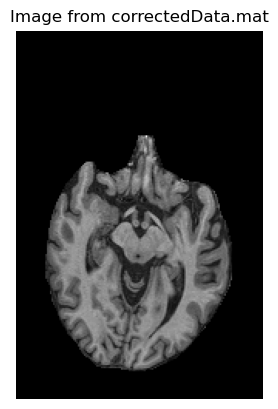

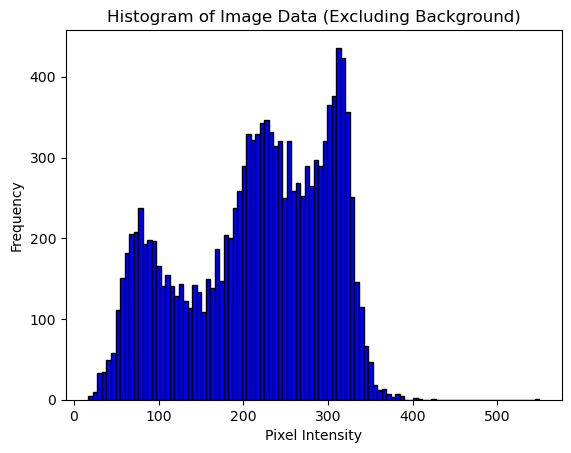

In [12]:
mat = loadmat("correctedData.mat")
data= mat["correctedData"]

plt.imshow(data, cmap='gray')  
plt.title("Image from correctedData.mat")
plt.axis("off")  
plt.show()

data_no_background = data[data > 0]  # Mask out zero values

plt.hist(data_no_background.flatten(), bins=100, color='blue', edgecolor='black')
plt.title("Histogram of Image Data (Excluding Background)")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()




## Task 2: Initialize Gaussian-Mixture Model
Compute the minimum and maximum intensity in the image (non-zero pixels), and divide the
intensity range up into three equally wide intervals. Initialize the parameters of a 3-component
Gaussian mixture model by setting the means of the Gaussians to the centers of the intensity
intervals, the variances to the square of the width of the intervals, and the prior weights to $\frac{1}{3}$ each.

> ***Hint:***
> - In your intensity range, disregard the background pixels by clipping 0

The minimum intensity 17.078205010324904
The maximum intensity 549.6669350144115
mu1: 105.84299334433933, mu2: 283.37257001236816, mu3: 460.90214668039704
sigma1^2: 31516.750591929533, sigma_2^2: 31516.750591929533, sigma_3^2: 31516.750591929533
pi1: 0.3333333333333333, pi2: 0.3333333333333333, pi3: 0.3333333333333333


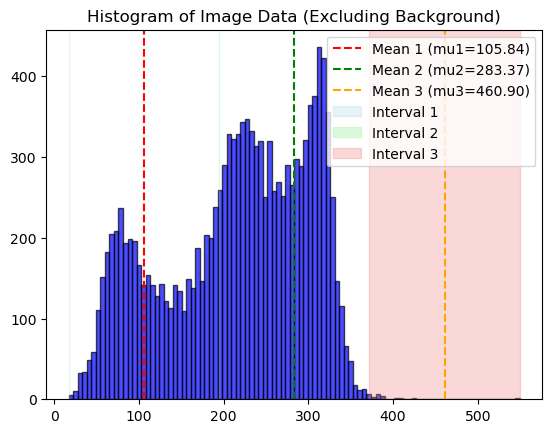

In [13]:
# Step 3: Compute the minimum and maximum intensity
min_intensity = np.min(data_no_background)
print("The minimum intensity", min_intensity)
max_intensity = np.max(data_no_background)
print("The maximum intensity", max_intensity)

interval_width = (max_intensity - min_intensity) / 3
mu1 = min_intensity + interval_width / 2
mu2 = min_intensity + 3 * interval_width / 2
mu3 = max_intensity - interval_width / 2
sigma1_2 = sigma2_2 = sigma3_2 = interval_width**2 

# Step 4: Set prior weights to 1/3 each
pi1 = pi2 = pi3 = 1 / 3


# Print initialized parameters
print(f"mu1: {mu1}, mu2: {mu2}, mu3: {mu3}")
print(f"sigma1^2: {sigma1_2}, sigma_2^2: {sigma2_2}, sigma_3^2: {sigma3_2}")
print(f"pi1: {pi1}, pi2: {pi2}, pi3: {pi3}")

# Plot histogram
plt.hist(data_no_background.flatten(), bins=100, color='blue', edgecolor='black', alpha=0.7)
plt.title("Histogram of Image Data (Excluding Background)")

# Plot vertical lines for the means (mu1, mu2, mu3)
plt.axvline(mu1, color='red', linestyle='dashed', label=f'Mean 1 (mu1={mu1:.2f})')
plt.axvline(mu2, color='green', linestyle='dashed', label=f'Mean 2 (mu2={mu2:.2f})')
plt.axvline(mu3, color='orange', linestyle='dashed', label=f'Mean 3 (mu3={mu3:.2f})')

# Mark the intervals with shading
plt.axvspan(min_intensity, mu1 - interval_width / 2, color='lightblue', alpha=0.3, label="Interval 1")
plt.axvspan(mu1 + interval_width / 2, mu2 - interval_width / 2, color='lightgreen', alpha=0.3, label="Interval 2")
plt.axvspan(mu2 + interval_width / 2, max_intensity, color='lightcoral', alpha=0.3, label="Interval 3")

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

## Task 3: Display inital Gaussian distributions
Overlay the resulting Gaussian mixture model on the histogram by plotting each
Gaussian weighted by its $\pi_k$, as well as the total weighted sum of all three Gaussian distributions
(as in fig. 3.1(b) in the course notes).

> ***Hint:***
> - A gaussian distribution with the parameters $\mu$, $\sigma^2$, scaled by the weight $w$ and evaluated at positions $x$ can be obtained by the function
>        
>        w * scipy.stats.norm.pdf( x, mu, sigma).
>
> - you can use the bin edges of your histogram as $x$.

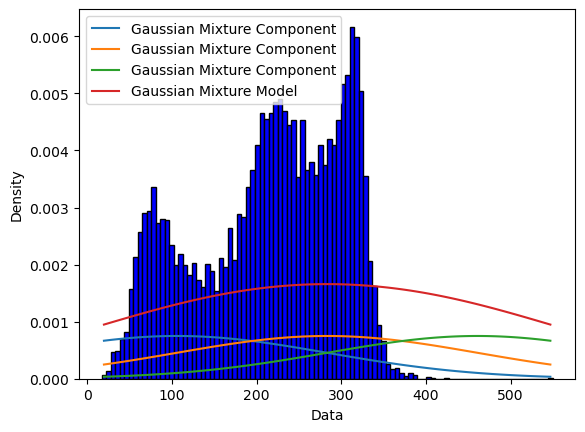

In [14]:

hist, bin_edges = np.histogram(data_no_background, bins=100)
plt.hist(data_no_background.flatten(), bins=100, color='blue', edgecolor='black',density=True)
x= (bin_edges[:-1] + bin_edges[1:])/2

means=[mu1, mu2, mu3]
variances=[sigma1_2, sigma2_2, sigma3_2]
weights=[pi1, pi2, pi3]

def compute_gaussian(x,mean,var):
    return scipy.stats.norm.pdf(x,mean,np.sqrt(var))


for mean,var,weight in zip(means,variances,weights):
   plt.plot(x,weight*compute_gaussian(x,mean,var),label='Gaussian Mixture Component')

total_pdf=np.zeros_like(x)

for mean,var,weight in zip(means,variances,weights):
    total_pdf+=weight*compute_gaussian(x,mean,var)


plt.plot(x,total_pdf,label='Gaussian Mixture Model')
plt.legend()
plt.xlabel('Data')
plt.ylabel('Density')
plt.legend()
plt.show()





## Task 4: Compute weights
Compute the values of ${w}_{n,k}$ defined by:

$$ \mathcal{w}_{n,k} = \frac{\mathcal{N}(d_n \vert \tilde{\mu}_k, \tilde{\sigma}^2_k) \tilde{\pi}_k}{\sum^K_{k'=1} \mathcal{N}(d_n \vert \tilde{\mu}_k', \tilde{\sigma}^2_{k'}) \tilde{\pi}_k'}. $$

Visualize the values of each ${w}_{n,k}$ in a figure. You should have three plots which each display only the pixels that belong to the respective class, according to the weights.

> ***Hint:***
> - The segmentation of a pixel is determined by assigning the class of the highest probability. 
> - In your visualization, disregard the background pixels by clipping 0

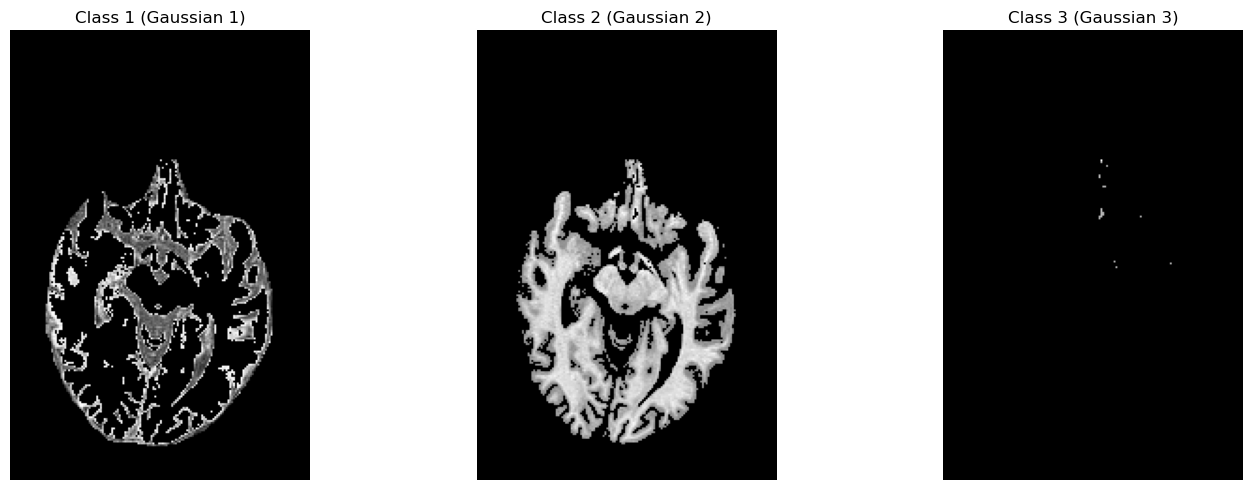

In [15]:

def computing_weights(data, means, variances, weights):
    # Initialize responsibilities array with shape (number of data points, 3 components)
    responsibilities = np.zeros((len(data), 3))
    
    # Iterate over each Gaussian component
    for k in range(3):
        pdf_k = compute_gaussian(data, means[k], variances[k])  # shape should match data
        responsibilities[:, k] = weights[k] * pdf_k  # Broadcasting weights[k] over pdf_k

    # Normalize responsibilities to get w_n,k (posterior probabilities)
    denominator = np.sum(responsibilities, axis=1)[:, np.newaxis]  # shape (len(data), 1)
    w_nk = responsibilities / denominator  # Divide each row by its corresponding sum

    return w_nk


w_nk = computing_weights(data_no_background,means,variances,weights)


max_class = np.argmax(w_nk, axis=1)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for k in range(3):
   
    mask = (max_class == k)
    
    class_image = np.zeros_like(data)
    class_image[data > 0] = mask * data_no_background
    
    
    axes[k].imshow(class_image, cmap='gray')
    axes[k].set_title(f"Class {k+1} (Gaussian {k+1})")
    axes[k].axis('off')

plt.tight_layout()
plt.show()

## Task 5: Estimate Maximum Likelihood parameters
Estimate the maximum likelihood parameters by iterating between updating the model parameter
estimate according to 

$$ \tilde{\mu_k} \leftarrow \frac{\sum^N_{n=1} w_{n,k} d_n}{\sum^N_{n=1} w_{n,k}}  $$

$$ \tilde{\sigma}^2_k \leftarrow \frac{\sum^N_{n=1} w_{n,k} (d_n - \tilde{\mu_k})^2}{\sum^N_{n=1} w_{n,k}}  $$

$$ \tilde{\pi_k} \leftarrow \frac{\sum^N_{n=1} w_{n,k}}{N}  $$

and by recomputing ${w}_{n,k}$ according to eq. 3.33 (see Task 4).

Make sure to perform enough iterations (e.g., 100) for the algorithm to converge. As the iterations progress, plot
the evolution of the log likelihood function, and update each time the display of ${w}_{n,k}$ as well as
the Gaussian mixture model plot overlaid on the histogram. Include the evolution of the log
likelihood function and the plot of the final ${w}_{n,k}$ and the final mixture model in your report.

> ***Hint:***
> - The log likelihood can be simply computed by
>       $\log ( \sum_k w_k x_k )$

Iteration 0, Log-Likelihood: -14580.782295203151


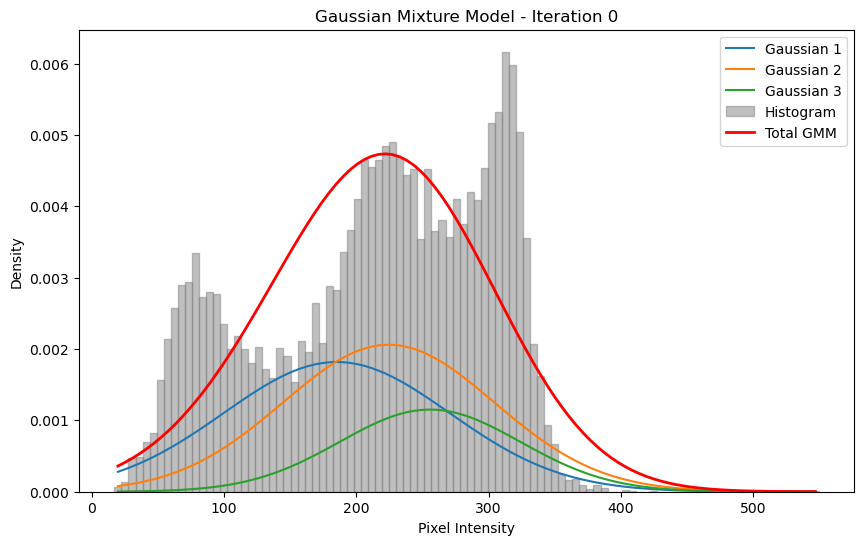

Iteration 10, Log-Likelihood: -14534.341872543875


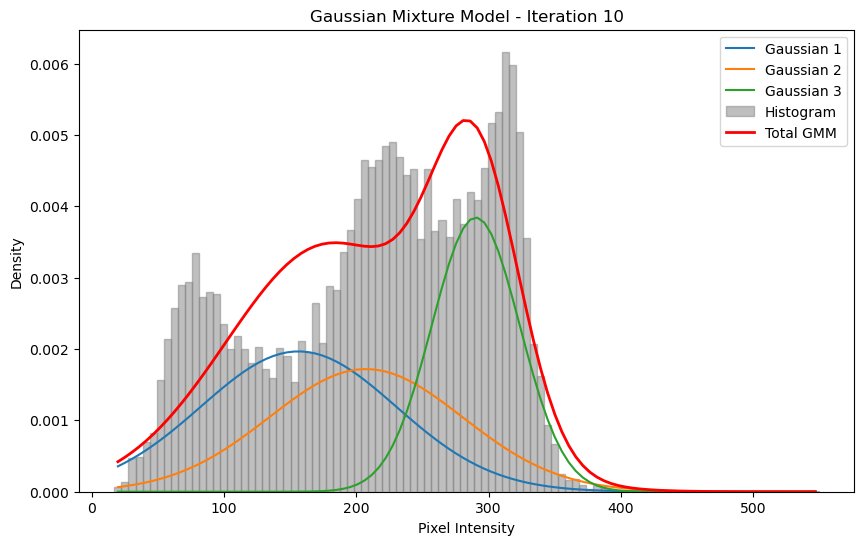

Iteration 20, Log-Likelihood: -14516.551209560834


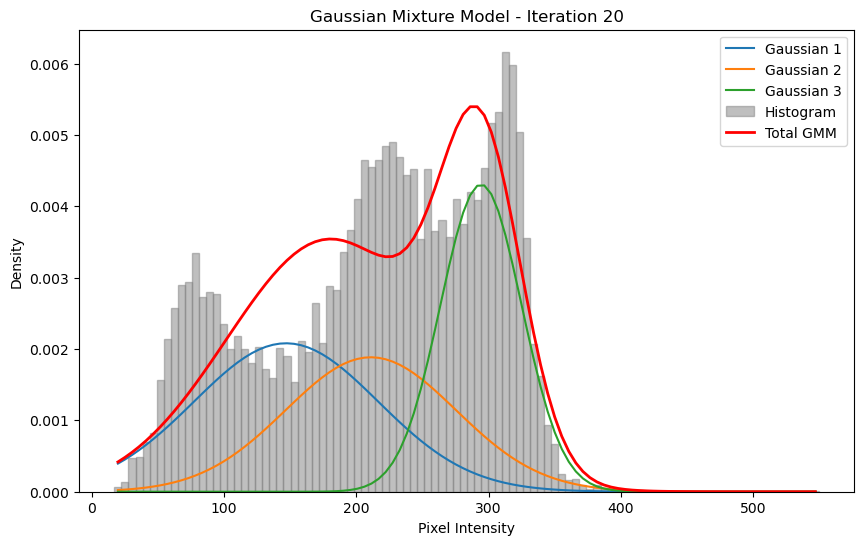

Iteration 30, Log-Likelihood: -14532.444920726994


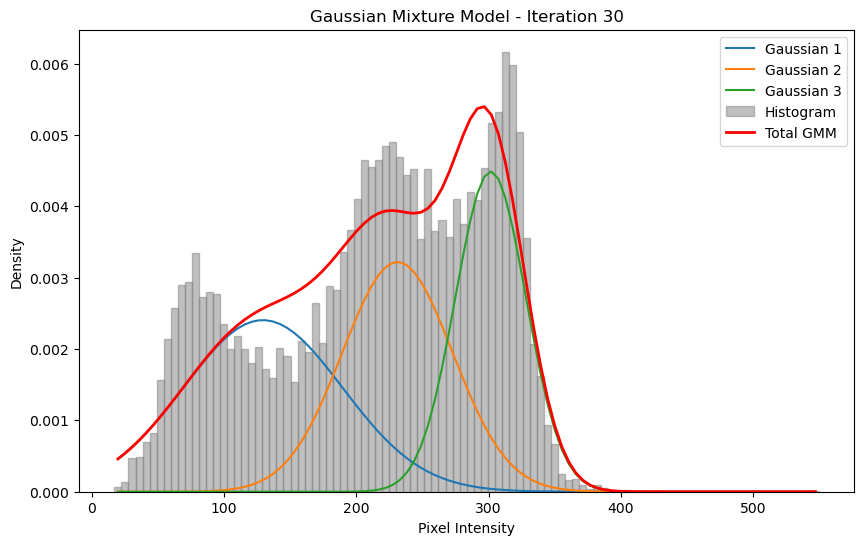

Iteration 40, Log-Likelihood: -14415.929691820758


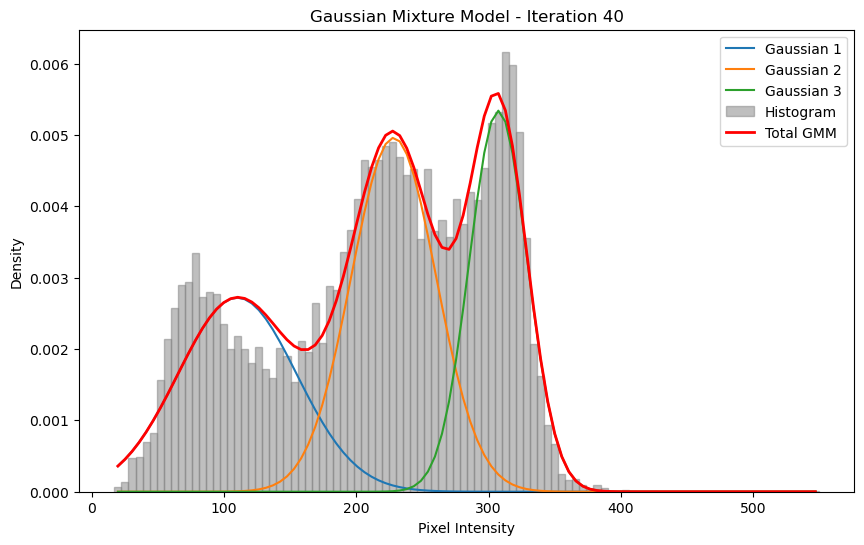

Iteration 50, Log-Likelihood: -14010.23263138193


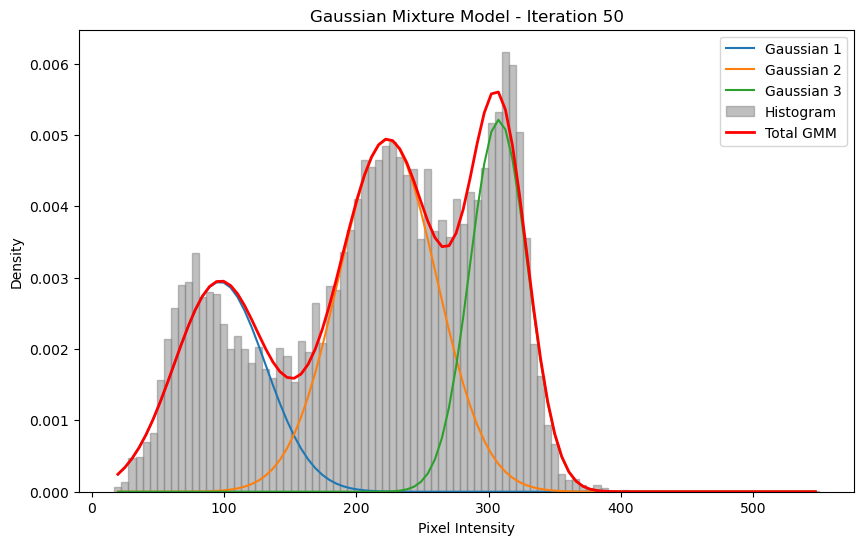

Iteration 60, Log-Likelihood: -13453.36002075683


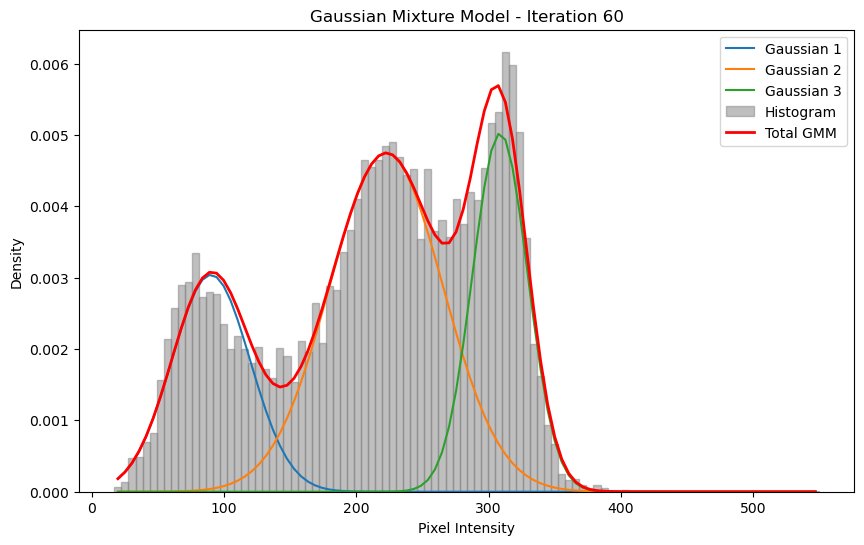

Iteration 70, Log-Likelihood: -12733.01756965972


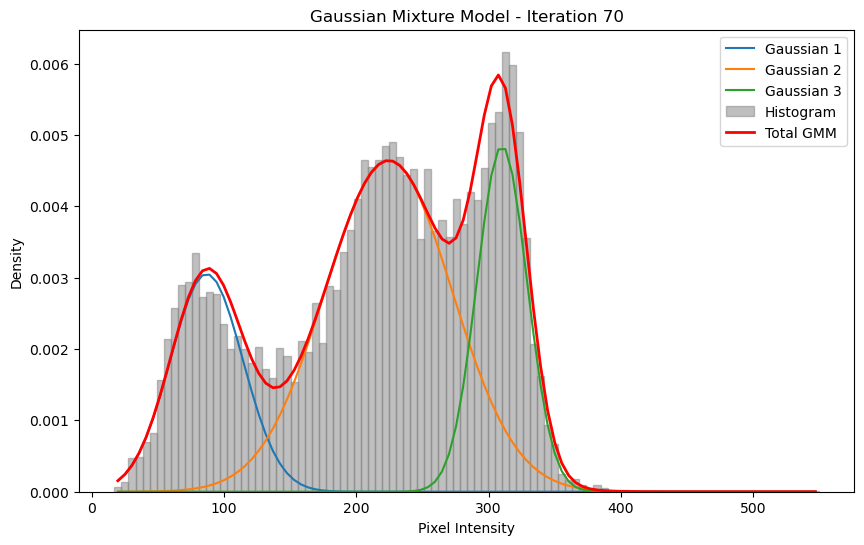

Iteration 80, Log-Likelihood: -12084.481577114322


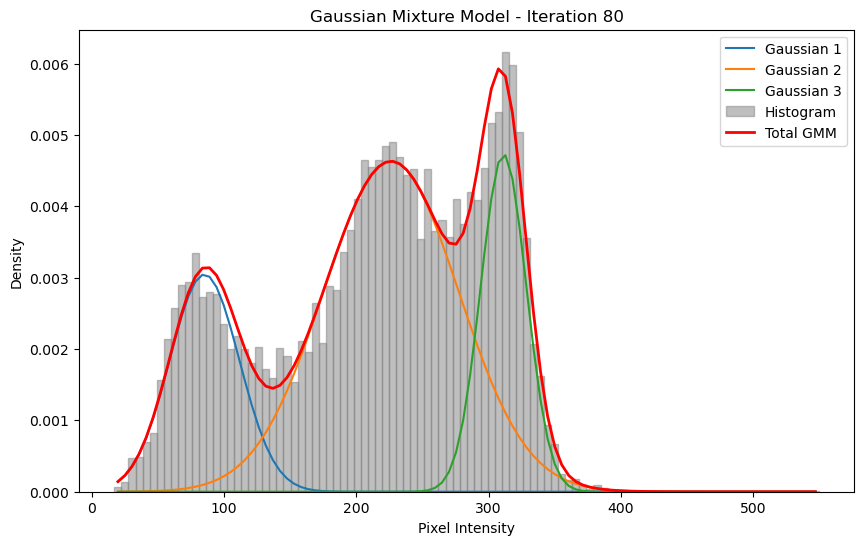

Iteration 90, Log-Likelihood: -11730.264465014445


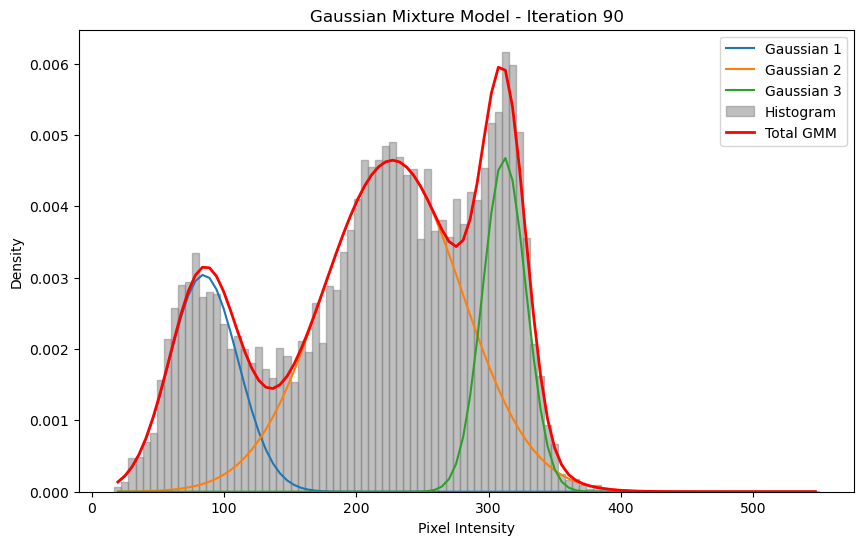

Iteration 100, Log-Likelihood: -11576.934243427593


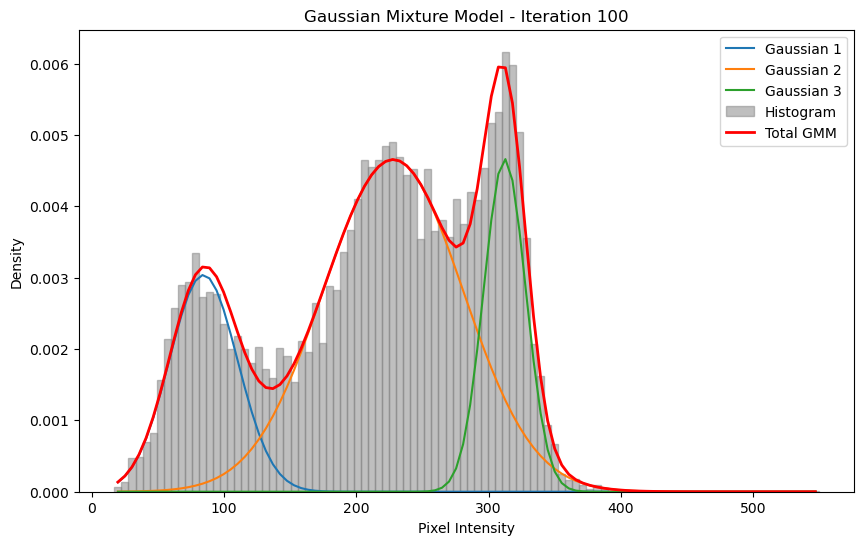

In [16]:

def compute_log_likelihood(data, means, variances, weights):
    responsibilities = computing_weights(data, means, variances, weights)
    log_likelihood = np.sum(np.log(np.sum(responsibilities* weights,axis=1 )))
    return log_likelihood, responsibilities

# EM Algorithm parameters and initialization
iterations = 110
log_likelihoods = []
param_history = {'means': [], 'variances': [], 'weights': []}

# Initialization of parameters (means, variances, weights)
means = [mu1, mu2, mu3]
variances = [sigma1_2, sigma2_2, sigma3_2]
weights = [pi1, pi2, pi3]

# EM Iterations
for iteration in range(iterations):
    # E-step: Compute responsibilities w_n,k
    log_likelihood, responsibilities = compute_log_likelihood(data_no_background, means, variances, weights)
    log_likelihoods.append(log_likelihood)
    
    # M-step: Update parameters based on responsibilities
    N = len(data_no_background)
    for k in range(3):
        # Update the means
        means[k] = np.sum(responsibilities[:, k] * data_no_background) / np.sum(responsibilities[:, k])
        # Update the variances
        variances[k] = np.sum(responsibilities[:, k] * (data_no_background - means[k])**2) / np.sum(responsibilities[:, k])
        # Update the weights
        weights[k] = np.sum(responsibilities[:, k]) / N

    # Store the parameters after each iteration
    param_history['means'].append(means.copy())
    param_history['variances'].append(variances.copy())
    param_history['weights'].append(weights.copy())
    
    # Display the log-likelihood evolution and the GMM plot every 10 iterations
    if iteration % 10 == 0:
        print(f"Iteration {iteration}, Log-Likelihood: {log_likelihood}")
        
        # Plot the GMM overlay on the histogram
        plt.figure(figsize=(10, 6))
        hist, bin_edges = np.histogram(data_no_background, bins=100, density=True)
        x = (bin_edges[:-1] + bin_edges[1:]) / 2  # Bin centers
        total_gmm = np.zeros_like(x)
        
        # Plot each Gaussian component
        for k in range(3):
            gaussian = weights[k] * compute_gaussian(x, means[k], variances[k])
            total_gmm += gaussian
            plt.plot(x, gaussian, label=f"Gaussian {k+1}")
        
        plt.hist(data_no_background, bins=100, density=True,alpha=0.5, color='gray', edgecolor='gray', label="Histogram")
        plt.plot(x, total_gmm, color='red', linewidth=2, label="Total GMM")
        plt.title(f"Gaussian Mixture Model - Iteration {iteration}")
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Density")
        plt.legend()
        plt.show()



110


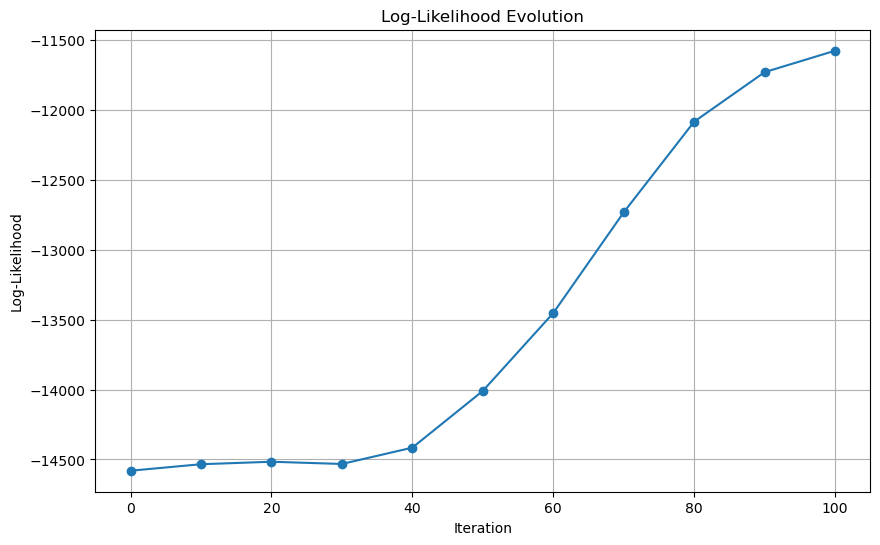

In [17]:

# Plot the final log-likelihood
plt.figure(figsize=(10, 6))
iterations = iterations = np.arange(0, 110, 10)
log_likelihood_subset = np.array(log_likelihoods)[iterations]
print(len(log_likelihoods))
plt.plot(iterations, log_likelihood_subset, marker='o')
plt.title("Log-Likelihood Evolution")
plt.xlabel("Iteration")
plt.ylabel("Log-Likelihood")
plt.grid(True)
plt.show()



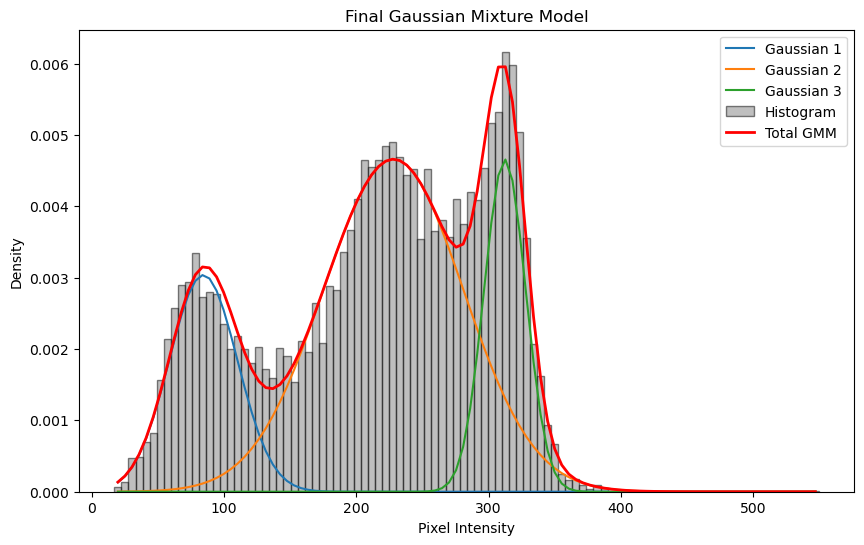

In [18]:

# Final GMM after convergence
plt.figure(figsize=(10, 6))
hist, bin_edges = np.histogram(data_no_background, bins=100, density=True)
x = (bin_edges[:-1] + bin_edges[1:]) / 2  # Bin centers
total_gmm = np.zeros_like(x)

for k in range(3):
    gaussian = weights[k] * norm.pdf(x, means[k], np.sqrt(variances[k]))
    total_gmm += gaussian
    plt.plot(x, gaussian, label=f"Gaussian {k+1}")

plt.hist(data_no_background, bins=100, density=True, alpha=0.5, color='gray', edgecolor='black', label="Histogram")
plt.plot(x, total_gmm, color='red', linewidth=2, label="Total GMM")
plt.title("Final Gaussian Mixture Model")
plt.xlabel("Pixel Intensity")
plt.ylabel("Density")
plt.legend()
plt.show()

## Task 6: Vary only one model parameter
Keeping all other parameters fixed to their estimated values, vary only $\mu_2$ (the mean of the middle
Gaussian distribution) between the estimated values of $\mu_1$ and $\mu_3$ in about 100 steps, and plot for
each step the log likelihood function.

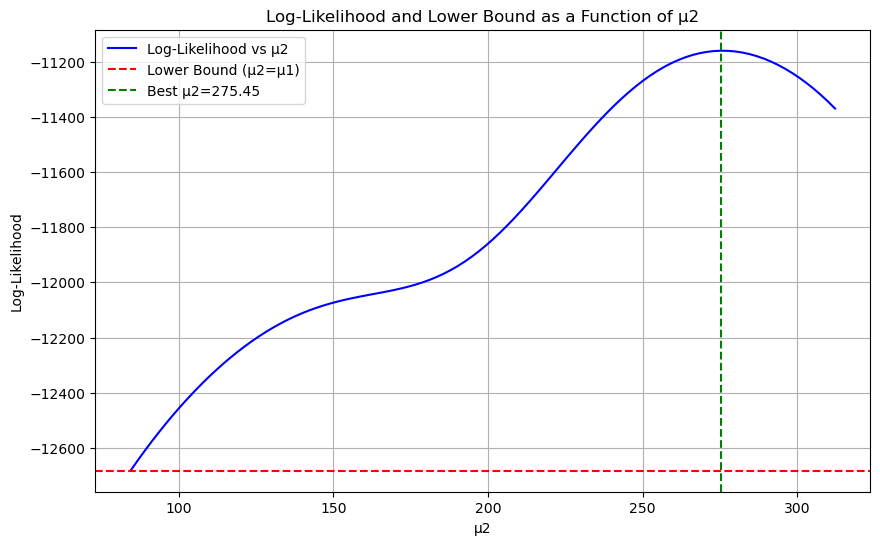

In [21]:
# Task 6: Vary μ2 and Compute Log-Likelihood
mu1, mu2, mu3 = param_history['means'][-1]  # Final estimated means
sigma1_2, sigma2_2, sigma3_2 = param_history['variances'][-1]
pi1, pi2, pi3 = param_history['weights'][-1]

mu2_range = np.linspace(mu1, mu3, 100)  # 100 steps between μ1 and μ3
log_likelihoods_mu2 = []

for mu2_val in mu2_range:
    means_temp = [mu1, mu2_val, mu3]
    log_likelihood, _ = compute_log_likelihood(data_no_background, means_temp, variances, weights)
    log_likelihoods_mu2.append(log_likelihood)

# Task 7: Lower Bound
# Fix μ2 to μ1
lower_bound_means = [mu1, mu1, mu3]
lower_bound_log_likelihood, _ = compute_log_likelihood(data_no_background, lower_bound_means, variances, weights)

# Task 8: Maximize Lower Bound
# Optimize μ2 to maximize the lower bound Q(θ|θ~)
best_mu2 = mu2_range[np.argmax(log_likelihoods_mu2)]
max_lower_bound = max(log_likelihoods_mu2)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(mu2_range, log_likelihoods_mu2, label="Log-Likelihood vs μ2", color="blue")
plt.axhline(y=lower_bound_log_likelihood, color="red", linestyle="--", label="Lower Bound (μ2=μ1)")
plt.axvline(x=best_mu2, color="green", linestyle="--", label=f"Best μ2={best_mu2:.2f}")
plt.title("Log-Likelihood and Lower Bound as a Function of μ2")
plt.xlabel("μ2")
plt.ylabel("Log-Likelihood")
plt.legend()
plt.grid(True)
plt.show()


## Task 7: Locate Lower bound
On the same figure, also plot the lower bound corresponding to the parameter vector in which all
parameters are set to their estimated values, except $\mu_2$ which is set to the estimated value of $\mu_1$.

ValueError: could not broadcast input array from shape (240,160) into shape (240,)

## Task 8: Maximize lower bound
Compute the value for $\mu_2$ that maximizes this lower bound (first line of eq. 3.35), indicate its location
on the figure, and comment on the result.

Formulate the lower bound as 

$$ Q(\theta \vert \tilde{\theta}) = -\frac{1}{2} \sum^K_{k=1} [\frac{1}{\sigma^2_k} \sum^N_{n=1} w_{n,k} (d_n - \mu_k - \sum^M_{m-1} c_m \phi_{n,m})^2 + (\sum^N_{n-1} w_{n,k}) \log \sigma^2_k] $$

$$ + \sum^K_{k=1} [(\sum^N_{n=1} w_{n,k}) \log \pi_k] $$

$$ - \sum^N_{n=1} \sum^K_{k=1} w_{n,k} \log w_{n,k} - \frac{N}{2} \log (2\pi) $$


Optimal mu_2 that maximizes the lower bound: 460.90214668039704


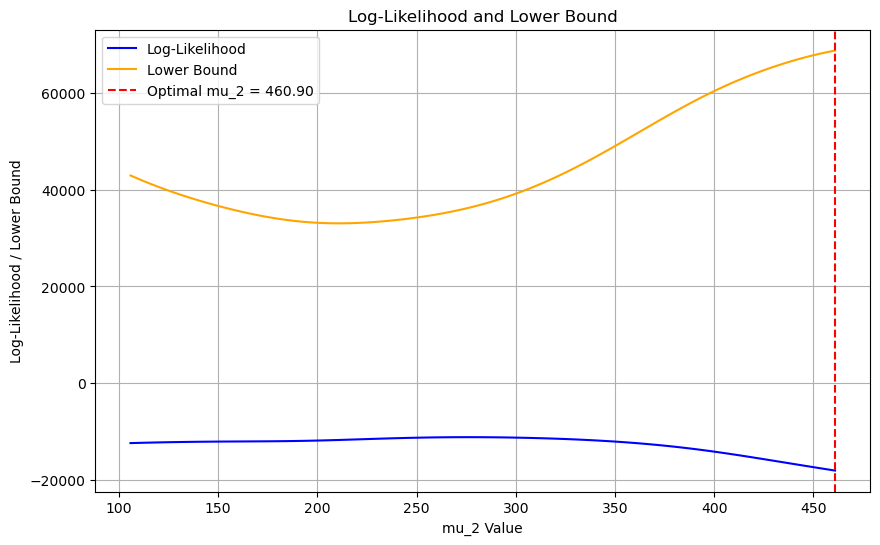